<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

# Model Checking

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

This is a tutorial for / demonstration of **Model Checking** with GeostatsPy. 

**YouTube Lecture**: check out my lectures on: 

* [Bootstrap](https://youtu.be/wCgdoImlLY0?si=lpTWz2H7QTdxHBy9)
* [Kriging](https://youtu.be/wCgdoImlLY0?si=lpTWz2H7QTdxHBy9)
* [Simulation](https://youtu.be/3cLqK3lR56Y?si=_fWhobX9AMOYEE_n)
* [Model Checking](https://youtu.be/AVms8JoUWXc?si=3zI4r5R6rYLyiXpz)

For your convenience here's a summary of salient points.

#### Spatial Spatial Modeling

There are a variety of spatial data analytics / geostatistics methods for estimation and simulation of spatial phenomenon. I cover many of these methods in my courses, lectures and demonstration workflows available on YouTube and GitHub.For example:

Yet, when we calculate these spatial deterministic estimates or stochastic realizations we must check these models. Here I provide a Python demonstration of spatial model checking inspired by the work of Leuangthong et al. (2004) known as [Minimum Acceptance Criteria for Geostatistical Realizations](https://link.springer.com/article/10.1023/B:NARR.0000046916.91703.bb).

I simulate a set of realizations for a publically available [dataset](https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv) from my GitHub account and include codes and good displays for each of the following checks:

1. Visualize the Spatial Models
2. Data Reproduction
3. Global Distributions - Summary Statistics
4. Global Distributions - PDFs and CDFs
5. Spatial Continuity - Variograms
6. Local Uncertainty Model - e-type and Conditional Standard Deviation

This is a basic demonstration and more could be done. 

* the models are 2D and univariate
* more checks such as accuracy plots for uncertainty cross validation could be applied

I have attempted to balance the need for a simple introduction for my students and others.

#### Load the Required Libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.71


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # supress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrys for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
import seaborn as sns
from scipy import stats                                       # summary statistics
import math                                                   # trig etc.
import scipy.signal as signal                                 # kernel for moving window calculation
import random
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Here's a convenience function for plotting variograms and calculating local summaries over realizations.

In [3]:
def vargplot(feature,lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi,atol,sill): # plot the variogram
    index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=100,xlag=10,azm=azi,vario=vmodel);
    index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=100,xlag=10,azm=azi+90.0,vario=vmodel);
    
    plt.scatter(lags,gamma_maj,color = 'black',s = npps_maj*0.01,label = 'Major Azimuth ' +str(azi), alpha = 0.2)
    plt.plot(lags_maj,gmod_maj,color = 'black')
    plt.scatter(lags,gamma_min,color = 'red',s = npps_min*0.01,label = 'Minor Azimuth ' +str(azi+90.0), alpha = 0.2)
    plt.plot(lags_min,gmod_min,color = 'red')
    plt.plot([0,2000],[sill,sill],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    if atol < 90.0:
        plt.title('Directional ' + feature + ' Variogram')
    else: 
        plt.title('Omni Directional NSCORE ' + feature + ' Variogram')
    plt.xlim([0,1000]); plt.ylim([0,1.5*sill]); plt.legend(loc="lower right")

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [4]:
os.chdir("c:/PGE383")                                        # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extra a limited sample so that the spatial samples are not too dense.  This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [5]:
dataset = 1

if dataset == 1:
    #df = pd.read_csv("sample_data_MV_biased.csv")             # read a .csv file in as a DataFrame
    df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # from Dr. Pyrcz's GitHub repo
    df['Porosity'] = df['Porosity']*100                                  # convert from fraction to percentage
    azi_maj = 45
elif dataset == 2:
    #df = pd.read_csv("spatial_nonlinear_MV_facies_v1.csv")    # read a .csv file in as a DataFrame
    df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v1.csv")
    df = df.rename(columns = {'Por':'Porosity'})            # rename feature(s)
    azi_maj = 135
else:
    raise Exception('Data Index = ' + str(dataset) + ' not available!')
    
df = df.loc[:,['X','Y','Porosity']];
df.describe().transpose()                                            # summary statistics 

,count,mean,std,min,25%,50%,75%,max
X,368.0,499.565217,289.770794,0.000000,240.000000,500.000000,762.500000,990.000000
Y,368.0,520.644022,277.412187,9.000000,269.000000,539.000000,769.000000,999.000000
Porosity,368.0,12.702582,3.064227,4.112152,10.341201,12.584177,14.862292,21.025763


#### Set Limits for Plotting and Colorbars and Grid Specification

Limits are applied for data and model visualization and the grid parameters sets the coverage and resolution of our map.

In [6]:
xmin = 0.0; xmax = 1000.0                                     # spatial limits
ymin = 0.0; ymax = 1000.0

nx = 100; xmn = 5.0; xsiz = 10.0                              # grid specification
ny = 100; ymn = 5.0; ysiz = 10.0

pormin = 0.0; pormax = 22.0                                   # feature limits
porvar = np.var(df['Porosity'].values)                        # assume data variance is representative

tmin = -9999.9; tmax = 9999.9                                 # triming limits

#### Data Analytics and Visualization

Let's take a look at the available data:

* location map
* histogram
* variogram

 x,y,z offsets = 7.071067805519558,7.071067818211393


 x,y,z offsets = 7.071067830903227,-7.071067792827723


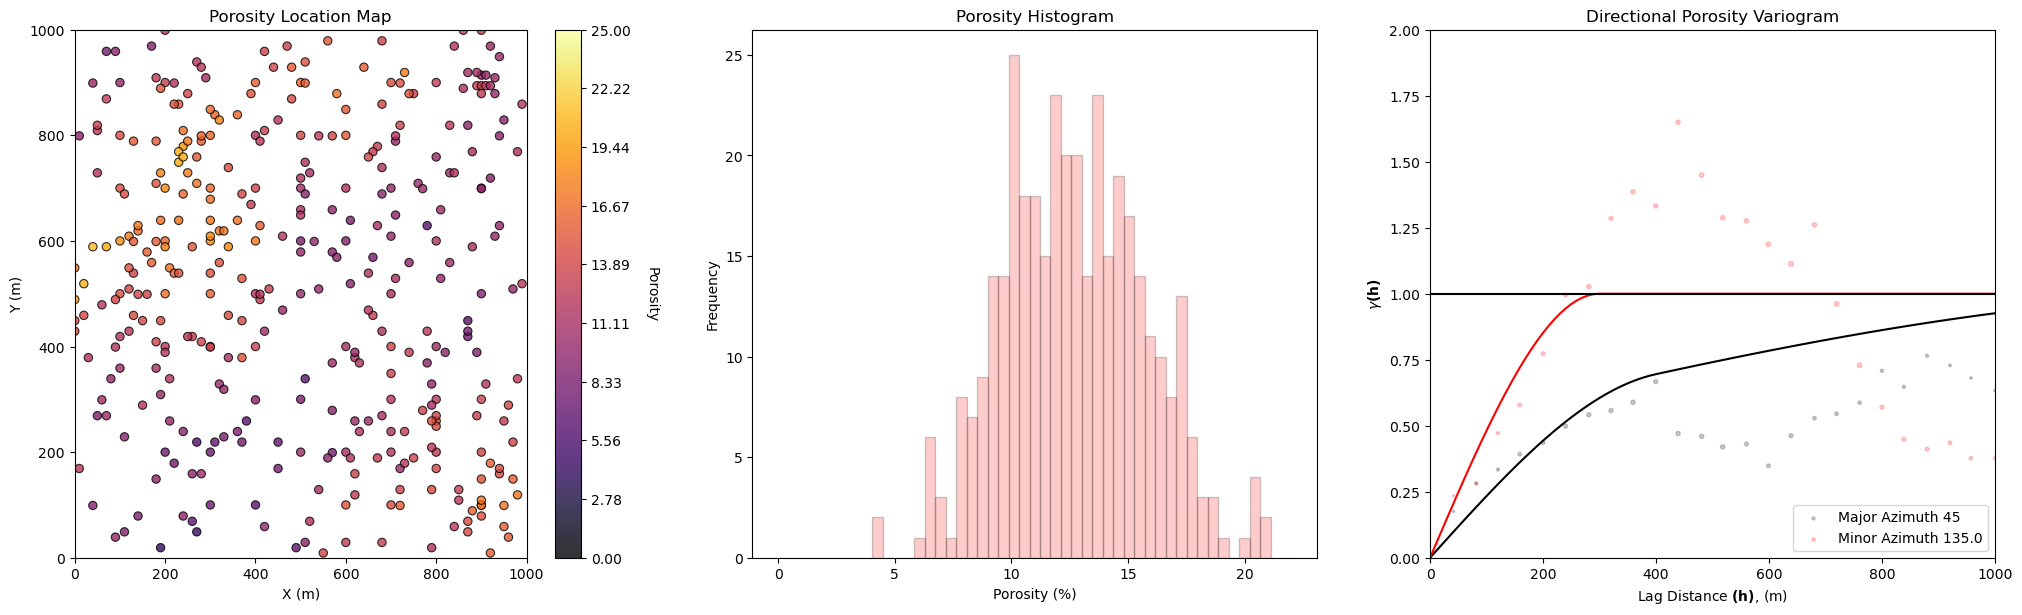

In [7]:
plt.subplot(131)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,25,'Porosity Location Map','X (m)','Y (m)','Porosity',cmap=cmap)

plt.subplot(132)
plt.hist(df['Porosity'].values,bins=np.linspace(pormin,pormax,50),color='red',alpha=0.2,edgecolor='black')
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('Porosity Histogram')

df['Npor'], tvPor, tnsPor = geostats.nscore(df,'Porosity') 
lags, gamma_maj, npps_maj = geostats.gamv(df,"X","Y",'Npor',tmin,tmax,xlag=40,xltol=20,nlag=100,azm=azi_maj,atol=12.5,bandwh=9999.9,isill=0);
lags, gamma_min, npps_min = geostats.gamv(df,"X","Y",'Npor',tmin,tmax,xlag=40,xltol=20,nlag=100,azm=azi_maj+90.0,atol=12.5,bandwh=9999.9,isill=0);

if dataset == 1:
    nug = 0.0; nst = 2                                        # 2 nest structure variogram model parameters
    it1 = 1; cc1 = 0.5; azi1 = azi_maj; hmaj1 = 400; hmin1 = 300
    it2 = 1; cc2 = 0.5; azi2 = azi_maj; hmaj2 = 1500; hmin2 = 300
elif dataset == 2:
    nug = 0.0; nst = 2                                        # 2 nest structure variogram model parameters
    it1 = 1; cc1 = 0.8; azi1 = azi_maj; hmaj1 = 50; hmin1 = 150
    it2 = 1; cc2 = 0.2; azi2 = mazi_maj; hmaj2 = 1000; hmin2 = 650

vmodel = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2); # make model object

plt.subplot(133)
vargplot('Porosity',lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi=azi_maj,atol=22.5,sill=1.0)     # plot the variogram
plt.ylim([0,2.0])

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Build an Example Modeling: Sequential Gaussian Simulated Realizations

Let's simulate a set of realizations with sequential Gaussian simulation ([GeostatsPy Python Package](https://pypi.org/project/geostatspy/) (Pyrcz et al., 2021) reimplemented from the original geostatistics open source, [GSLIB](http://www.gslib.com/) (Deutsch and Journel, 1997).

* we demonstrate 12 realizations by changing the random number seed. 
* this workflow and each check are general and could be applied to any set of spatial models representing uncertainty 

In [8]:
run = False; nreal = 12                                        # number of realizations

if run == True:
    por_sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,
        dftrans=0,tcol=0,twtcol=0,zmin=pormin,zmax=pormax,ltail=1,ltpar=pormin,utail=1,utpar=pormax,nsim=nreal,
        nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
        ndmin=0,ndmax=20,nodmax=20,mults=0,nmult=2,noct=-1,
        ktype=0,colocorr=0.0,sec_map=0,vario=vmodel)
    GSLIB.ndarray2GSLIB_3D(por_sim,"por_sim_realizations.dat","porosity") # write out 2D array to a Geo-DAS ASCII file
else: 
    por_sim = GSLIB.GSLIB2ndarray_3D("por_sim_realizations.dat",0,nreal,nx,ny,1)[0]

Now we are ready to step through the spatial model checks.

#### Model Check \#1: Visualize the Spatial Models

Look at the spatial estimates and / or stochastic realizations and check for common issues such as:

* **missing values** - part of the model not simulated
* **rotated, flipped or translated** - issues with the coordinate scheme
* **search artifacts** - discontinuities and rays caused by overly limited radius or maximum number of data
* **data not present** - error in data loading or data to grid consistency
* **extrapolation** - unexpected behavoir of the model away from the data

Visualization of the model realizations is an important first check.

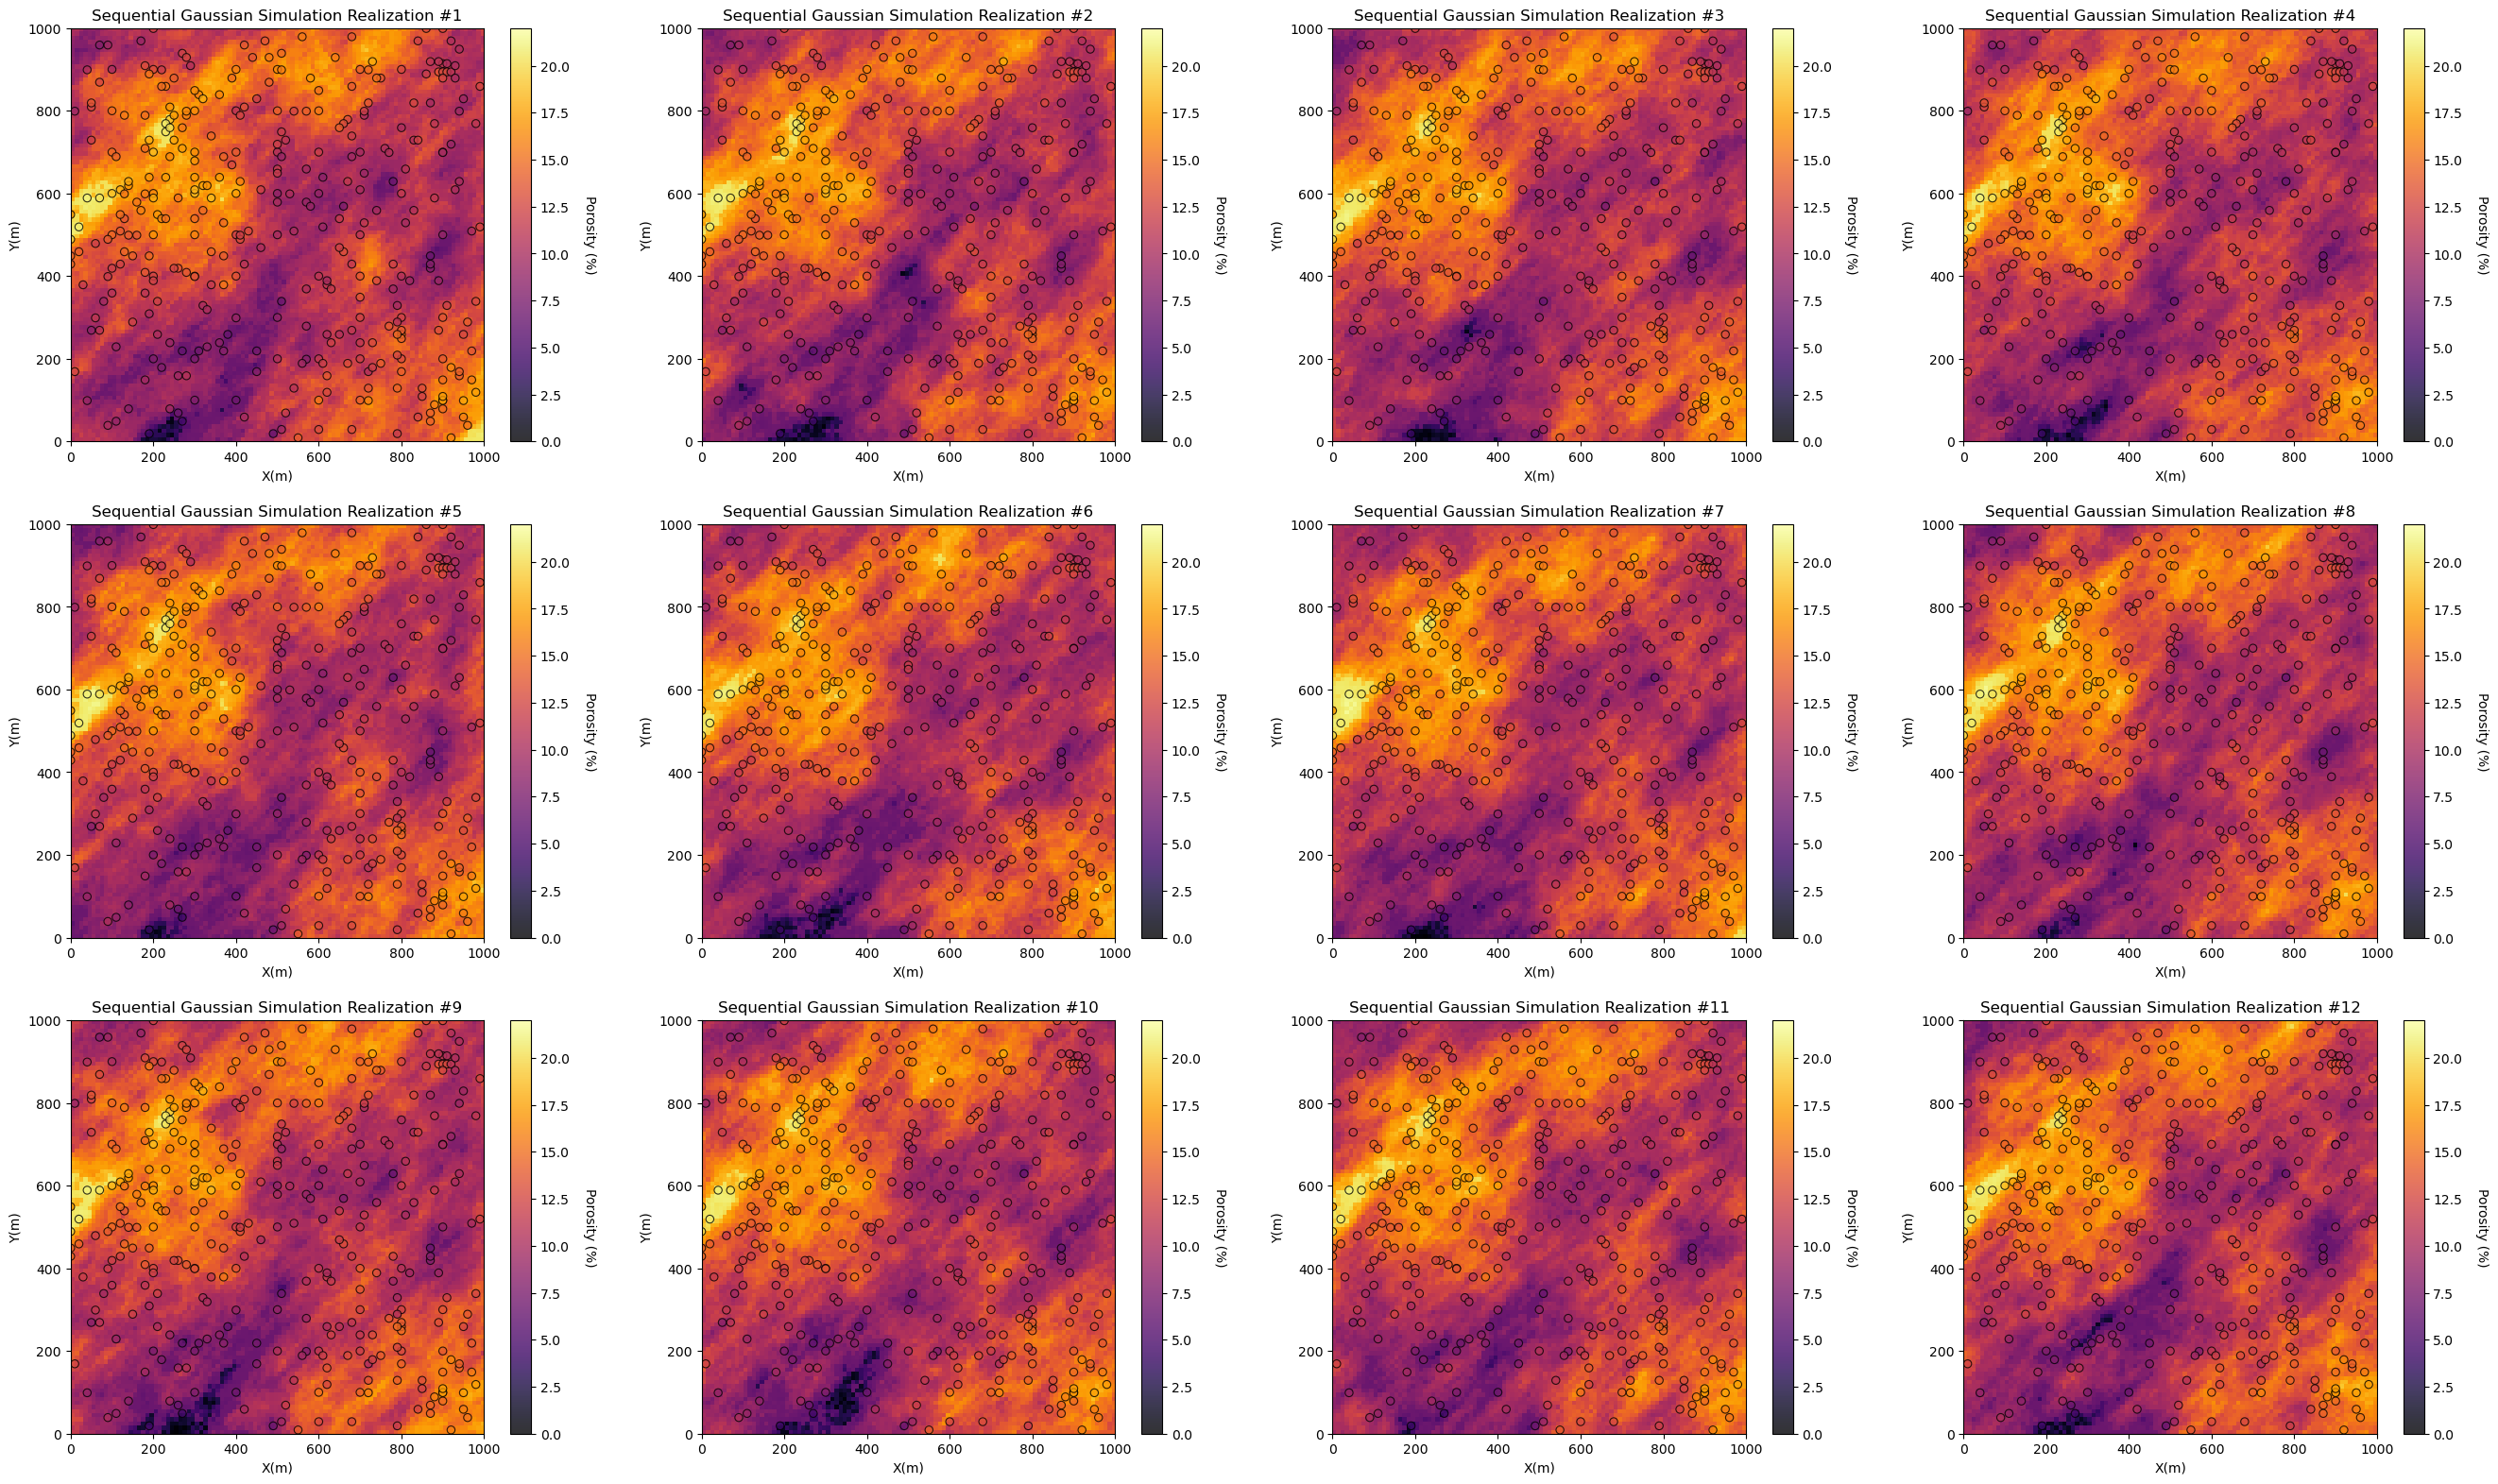

In [9]:
for ireal in range(0,nreal):
    plt.subplot(3,4,ireal+1)                                  # plot the data and realizations
    GSLIB.locpix_st(por_sim[ireal,:,:],xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Sequential Gaussian Simulation Realization #' + str(ireal+1),'X(m)','Y(m)','Porosity (%)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=3.1, wspace=0.2, hspace=0.2); plt.show()

For the provided data and simulated realizations 'look good': 

* the data is in the model space - no obvious well coordinates and grid specification inconsistencies. 
* the models honor the data at the data locations - no discontinuities at or near the data
* the heterogeneity is consistent over the models - no changes in scale and orientation over the model
* there are no missing values - no null values in the realizations

#### Model Check \#2: Data Reproduction

We need to check the reproduction of the data values at the data locations. Data is important and expensive, a model that fails to honor the data will not forecast well and will certainly loose credibility. 

Some further comments:

* **data scaling** - the data should be first scaled to the model grid cell scale
* **built-in scaling** - some methods have built in scaling that may cause apparent data and model mismatch
* **assignment of data to nearest cell** - some methods automatically do this resulting in perfect reproduction, SGSIM in GeostatsPy does not do this, so there is likely some scatter due to the assumption of point data 

We will find the cell that includes each data point and report the associated simulated realizations vs. the data points.

* we should see some vertical striations due to multiple realizations for each data value

In [10]:
# from tqdm import tqdm # progress bar

# def conditioning_check(model,nx,xmn,xsiz,ny,ymn,ysiz,df,xcol,ycol,vcol,vname,vmin,vmax):
#     iix = np.zeros(len(df),dtype = int); iiy = np.zeros(len(df),dtype = int)
#     for idata in range(0,len(df)):                                # find the model ix, iy cells at data x, y
#         iix[idata] = max(0,min(int((df.loc[idata,xcol] - xmin)/xsiz),nx-1))
#         iiy[idata] = ny - max(0,min(int((df.loc[idata,ycol] - ymin)/ysiz),ny-1))-1
        
#     real_por = np.zeros(len(df))
#     all_data = np.zeros(len(df)*nreal)
#     all_real = np.zeros(len(df)*nreal)
    
#     i = 0
#     for ireal in tqdm(range(0,nreal)):                            # make an array of all realizations paired to data values
#         for idata in range(0,len(df)): 
#             real_por[idata] = model[ireal,iiy[idata],iix[idata]]  
#             all_data[i] = df.loc[idata,vcol]
#             all_real[i] = real_por[idata]
#             i = i + 1
#         df['Real' + str(ireal+1)] = real_por 
    
#     df_vstack = pd.DataFrame(np.vstack((all_data, all_real)).T,columns = ['Data','Real']) # convert to a DataFrame
        
#     plt.scatter(all_data,all_real,alpha=0.2,color='black',s=5)
#     plt.plot([vmin,vmax],[vmin,vmax],color='black',linestyle='--')
#     plt.ylabel('Simulated Realizations - ' + vname); plt.xlabel('Data Values - ' + vname); plt.title('Data Reproduction Check - ' + vname)
#     plt.grid(True); plt.xlim([vmin,vmax]); plt.ylim([vmin,vmax])
#     return df_vstack

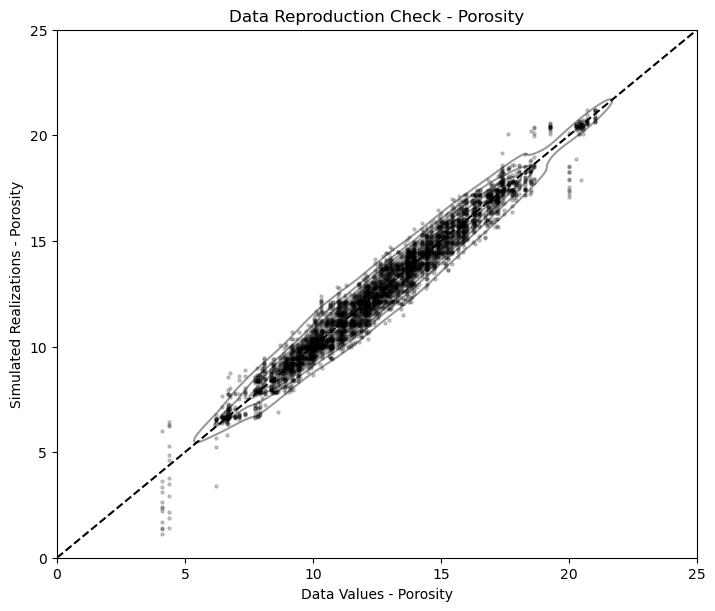

In [11]:
plt.subplot(111)
df_vstack = GSLIB.conditioning_check(model=por_sim,nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,nreal=nreal,
        df=df,xcol='X',ycol='Y',vcol='Porosity',vname='Porosity',vmin=0.0,vmax=25)
sns.kdeplot(data=df_vstack, x="Data", y="Real",color='black',alpha=0.4,label ="Train Density") # estimate joint PDF
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

Due to the use of point data and cells represented by points at the cell centroids, there is some scatter in the result above.

#### Model Check \#3: Global Distributions - Summary Statistics

While there will be ergodic fluctuations in reproduction of any statistics, we check the summary statistics of the global distribution for good match over the realizations, in expectation.

Here's some issues that we may see:

* **systematic bias** - measures of central tendency that are consistently shifted
* **reduced variance** - various modeling methods are subjected to regression to the mean, artificial loss in variance
* **outliers** - unusual estimated or simulated values

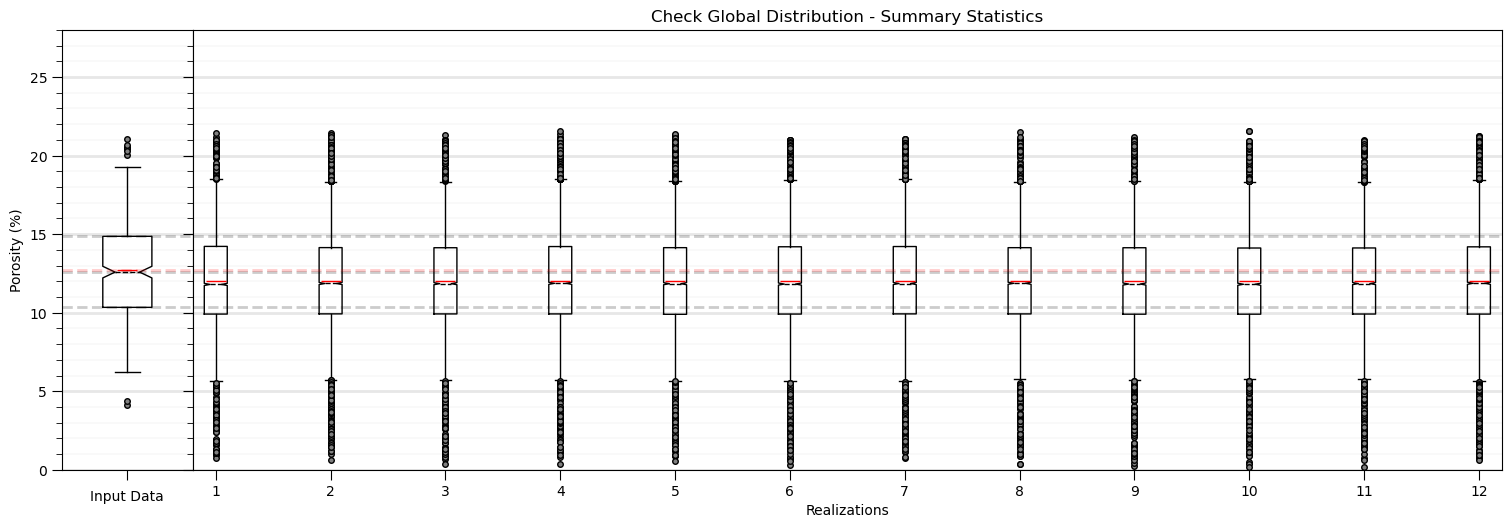

In [12]:
boxprops = dict(linewidth=1.0, color='black')
whiskerprops = dict(linestyle='-',linewidth=1.0, color='black')
medianprops = dict(linestyle='--',linewidth=1.0, color='black')
meanprops={"marker":'_', 'markersize': 15,"markerfacecolor":"red", "markeredgecolor":'red'}
flierprops={'marker': 'o', 'markersize': 4, 'markerfacecolor': 'grey','markeredgecolor':'black'}

por = df['Porosity'].values

fig, axs = plt.subplots(1,2,figsize=(16,5), gridspec_kw={'width_ratios': [1, 10]}, sharey = True)

axs[0].boxplot(df['Porosity'].values,labels = [''],whis=True,showmeans=True,widths=0.3,notch=True,boxprops=boxprops, whiskerprops=whiskerprops,meanprops=meanprops,flierprops=flierprops,medianprops=medianprops)
axs[0].set_ylim([0,28]); axs[0].set_ylabel('Porosity (%)'); axs[0].set_xlabel('Input Data'); axs[0].set_title('')
axs[0].grid(True,alpha=0.3,axis='y'); axs[0].set_xlim([1-0.4,1+0.4])
axs[0].plot([1-0.4,1+0.4],[np.percentile(por,75),np.percentile(por,75)],color='black',alpha=0.2,linestyle='--',linewidth=2)
axs[0].plot([1-0.4,1+0.4],[np.percentile(por,50),np.percentile(por,50)],color='black',alpha=0.2,linestyle='--',linewidth=2)
axs[0].plot([1-0.4,1+0.4],[np.percentile(por,25),np.percentile(por,25)],color='black',alpha=0.2,linestyle='--',linewidth=2)
axs[0].yaxis.set_minor_locator(plt.MultipleLocator(20))   
axs[0].plot([1-0.4,1+0.4],[np.average(por),np.average(por)],color='red',alpha=0.2,linestyle='--',linewidth=2)

axs[0].yaxis.grid(True, which='major',linewidth = 2.0); axs[0].yaxis.grid(True, which='minor',linewidth = 0.1) # add y grids
axs[0].tick_params(which='major',length=7); axs[0].tick_params(which='minor', length=4)
axs[0].yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

axs[1].boxplot(por_sim.reshape(ny*nx,nreal),whis=True,showmeans=True,widths=0.2,notch=True,boxprops=boxprops, whiskerprops=whiskerprops,meanprops=meanprops,flierprops=flierprops,medianprops=medianprops)
axs[1].set_ylim([0,28]); axs[1].set_ylabel(''); axs[1].set_xlabel('Realizations'); axs[1].set_title('Check Global Distribution - Summary Statistics')
axs[1].grid(True,alpha=0.3,axis='y'); axs[1].set_xlim([1-0.2,nreal+0.2])
axs[1].plot([1-0.2,nreal+0.2],[np.percentile(por,75),np.percentile(por,75)],color='black',alpha=0.2,linestyle='--',linewidth=2)
axs[1].plot([1-0.2,nreal+0.2],[np.percentile(por,50),np.percentile(por,50)],color='black',alpha=0.2,linestyle='--',linewidth=2)
axs[1].plot([1-0.2,nreal+0.2],[np.percentile(por,25),np.percentile(por,25)],color='black',alpha=0.2,linestyle='--',linewidth=2)
axs[1].plot([1-0.2,nreal+0.2],[np.average(por),np.average(por)],color='red',alpha=0.2,linestyle='--',linewidth=2)

axs[1].yaxis.grid(True, which='major',linewidth = 2.0); axs[1].yaxis.grid(True, which='minor',linewidth = 0.1) # add y grids
axs[1].tick_params(which='major',length=7); axs[1].tick_params(which='minor', length=4)
axs[1].yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks


plt.subplots_adjust(left=0.0, bottom=0.0, wspace=0.0, hspace=0.2)
plt.show()

In [13]:
# def distribution_check(df,vcol,model,nx,ny,nreal,dreal,vname,vmin,vmax):

#     boxprops = dict(linewidth=1.0, color='black')
#     whiskerprops = dict(linestyle='-',linewidth=1.0, color='black')
#     medianprops = dict(linestyle='--',linewidth=1.0, color='black')
#     meanprops={"marker":'_', 'markersize': 15,"markerfacecolor":"red", "markeredgecolor":'red'}
#     flierprops={'marker': 'o', 'markersize': 4, 'markerfacecolor': 'grey','markeredgecolor':'black'}
    
#     refdist = df[vcol].values
    
#     fig, axs = plt.subplots(1,2,figsize=(16,5), gridspec_kw={'width_ratios': [1, 10]}, sharey = True)
    
#     axs[0].boxplot(refdist,labels = [''],whis=True,showmeans=True,widths=0.3,notch=True,boxprops=boxprops, whiskerprops=whiskerprops,meanprops=meanprops,flierprops=flierprops,medianprops=medianprops)
#     axs[0].set_ylim([0,28]); axs[0].set_ylabel('vname'); axs[0].set_xlabel('Input Data'); axs[0].set_title('')
#     axs[0].grid(True,alpha=0.3,axis='y'); axs[0].set_xlim([1-0.4,1+0.4])
#     axs[0].plot([1-0.4,1+0.4],[np.percentile(por,75),np.percentile(por,75)],color='black',alpha=0.2,linestyle='--',linewidth=2)
#     axs[0].plot([1-0.4,1+0.4],[np.percentile(por,50),np.percentile(por,50)],color='black',alpha=0.2,linestyle='--',linewidth=2)
#     axs[0].plot([1-0.4,1+0.4],[np.percentile(por,25),np.percentile(por,25)],color='black',alpha=0.2,linestyle='--',linewidth=2)
#     axs[0].yaxis.set_minor_locator(plt.MultipleLocator(20))   
#     axs[0].plot([1-0.4,1+0.4],[np.average(por),np.average(por)],color='red',alpha=0.2,linestyle='--',linewidth=2)
    
#     axs[0].yaxis.grid(True, which='major',linewidth = 2.0); axs[0].yaxis.grid(True, which='minor',linewidth = 0.1) # add y grids
#     axs[0].tick_params(which='major',length=7); axs[0].tick_params(which='minor', length=4)
#     axs[0].yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
#     tarray = por_sim.reshape(nreal,ny*nx).T
#     axs[1].boxplot(tarray[:,:dreal],whis=True,showmeans=True,widths=0.2,notch=True,boxprops=boxprops, whiskerprops=whiskerprops,meanprops=meanprops,flierprops=flierprops,medianprops=medianprops)
#     axs[1].set_ylim([vmin,vmax]); axs[1].set_ylabel(''); axs[1].set_xlabel('Realizations'); axs[1].set_title('Check Global ' + vname + ' Distribution - Summary Statistics')
#     axs[1].grid(True,alpha=0.3,axis='y'); axs[1].set_xlim([1-0.2,dreal+0.2])
#     axs[1].plot([1-0.2,dreal+0.2],[np.percentile(por,75),np.percentile(por,75)],color='black',alpha=0.2,linestyle='--',linewidth=2)
#     axs[1].plot([1-0.2,dreal+0.2],[np.percentile(por,50),np.percentile(por,50)],color='black',alpha=0.2,linestyle='--',linewidth=2)
#     axs[1].plot([1-0.2,dreal+0.2],[np.percentile(por,25),np.percentile(por,25)],color='black',alpha=0.2,linestyle='--',linewidth=2)
#     axs[1].plot([1-0.2,dreal+0.2],[np.average(por),np.average(por)],color='red',alpha=0.2,linestyle='--',linewidth=2)
    
#     axs[1].yaxis.grid(True, which='major',linewidth = 2.0); axs[1].yaxis.grid(True, which='minor',linewidth = 0.1) # add y grids
#     axs[1].tick_params(which='major',length=7); axs[1].tick_params(which='minor', length=4)
#     axs[1].yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks
#     return



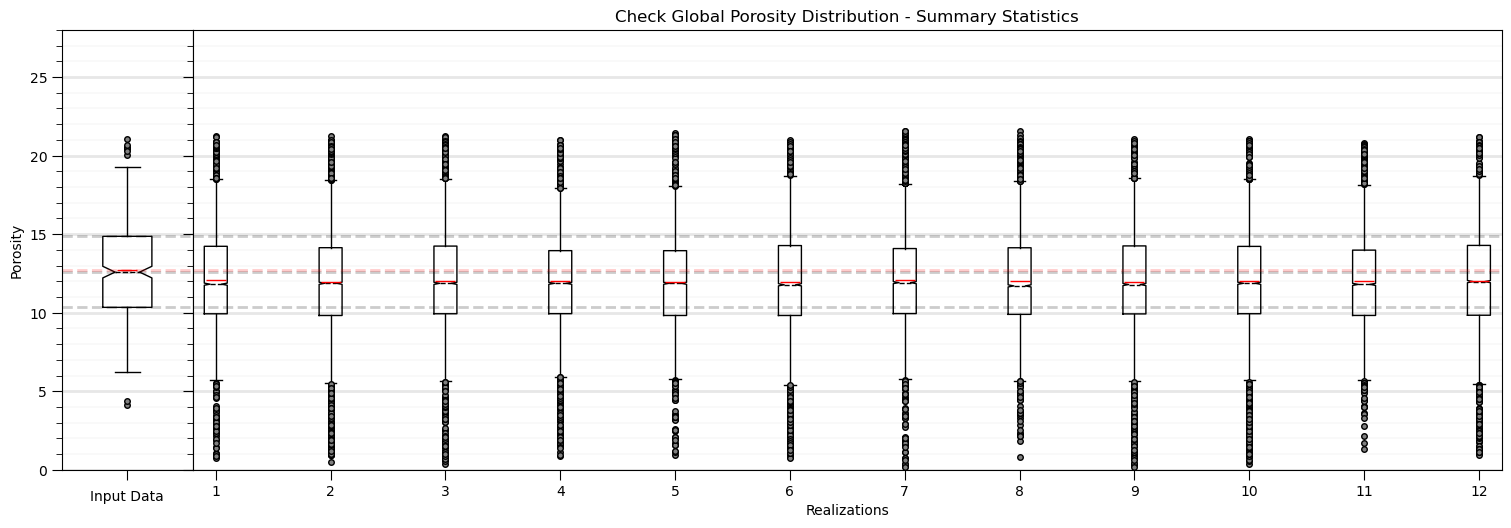

In [14]:
GSLIB.distribution_check(df=df,vcol='Porosity',model=por_sim,nx=nx,ny=ny,nreal=12,dreal=12,vname='Porosity',vmin=0.0,vmax=28.0)
plt.subplots_adjust(left=0.0, bottom=0.0, wspace=0.0, hspace=0.2); plt.show()

In general, this look pretty good. Some observations:

* there may be a shift low in the central tendency likely caused by the dense, clustered data, informing a degree of declustering in the simulation.
* otherwise the fluctuations are not extreme and could be checked with theory, e.g., analytical volume variance relations

#### Model Check \#4: Global Distributions - PDFs and CDFs

We can go beyond summary statistics and check the entire global distribution of the realizations vs. the input data. We check the probability density functions (PDFs) (infered with kernel density estimation) and cumulative distribution functions (CDFs).

* we check the shape, including the modes, symmetry and tails

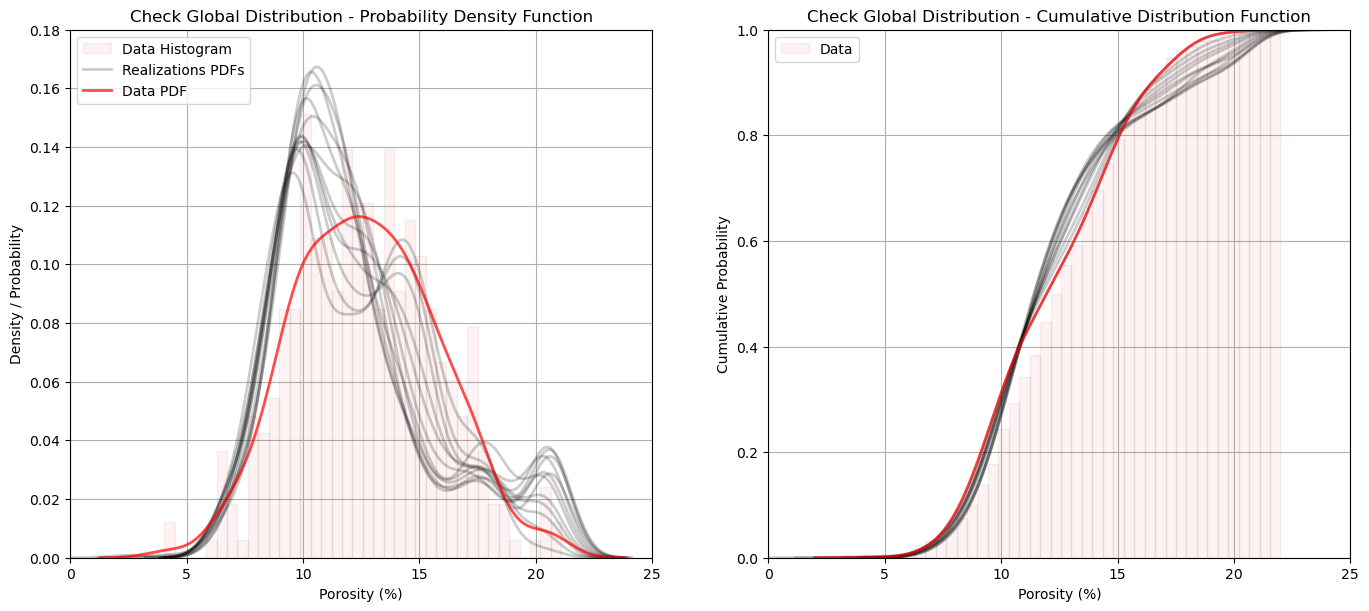

In [15]:
plt.subplot(121)
plt.hist(df['Porosity'].values,density=True,bins=np.linspace(pormin,pormax,50),color='red',alpha=0.05,edgecolor='black',label='Data Histogram')
for ireal in range(1,nreal):
#     plt.hist(por_sim[:,:,ireal].flatten(),density=True,bins=np.linspace(pormin,pormax,50),color='yellow',alpha=0.2,edgecolor='black',label='Simulation')
    sns.kdeplot(por_sim[:,:,ireal].flatten(), color = 'black',alpha=0.2,linewidth = 2)
    plt.xlabel('Porosity (%)'); plt.ylabel('Density / Probability'); plt.title('Check Global Distribution - Probability Density Function')
sns.kdeplot(por_sim[:,:,0].flatten(), color = 'black',alpha=0.2,linewidth = 2,label='Realizations PDFs')
sns.kdeplot(df['Porosity'].values, color = 'red',alpha=0.7,linewidth=2.0,label='Data PDF')
plt.xlim([0,25]); plt.ylim([0,0.18]); plt.grid(True); plt.legend(loc='upper left')

plt.subplot(122)
plt.hist(df['Porosity'].values,density=True,bins=np.linspace(pormin,pormax,50),color='red',alpha=0.05,edgecolor='black',label='Data',cumulative=True)
for ireal in range(0,nreal):
#     plt.hist(por_sim[:,:,ireal].flatten(),density=True,bins=np.linspace(pormin,pormax,50),color='yellow',alpha=0.2,edgecolor='black',label='Simulation')
    sns.kdeplot(por_sim[:,:,ireal].flatten(), color = 'black',alpha=0.2,linewidth = 2,cumulative=True)
    plt.xlabel('Porosity (%)'); plt.ylabel('Cumulative Probability'); plt.title('Check Global Distribution - Cumulative Distribution Function')
sns.kdeplot(por_sim[:,:,ireal].flatten(), color = 'red',alpha=0.7,linewidth=2,cumulative=True)
plt.xlim([0,25]); plt.ylim([0,1]); plt.grid(True); plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.2, hspace=0.2); plt.show()

The reproduction of the data distribution shape looks very good. I include the regular data normalized histogram to help visualize the impact of the kernel density estimate of the PDF.

* there is a minor shift in the mean and mode as discussed previously.

#### Model Check \#5: Spatial Continuity - Variograms

The variogram is an input statistic to constrain spatial continuity for sequential Gaussian simulation. Let's check the reproduction of the variogram. Some common issues:

* **underrepresent the range** - this is typically caused by overly limited search for nearest data and previously simulated nodes
* **trend structures** - even if the variogram is modeled to the sill and mean assumed to be stationary, dense data may impart a trend in the simulated realizations
* **scale change** - the raw data may represent very small lag distances, while the grid has a reoslution limit based on the cell size

 x,y,z offsets = 7.071067805519558,7.071067818211393
 x,y,z offsets = 7.071067830903227,-7.071067792827723


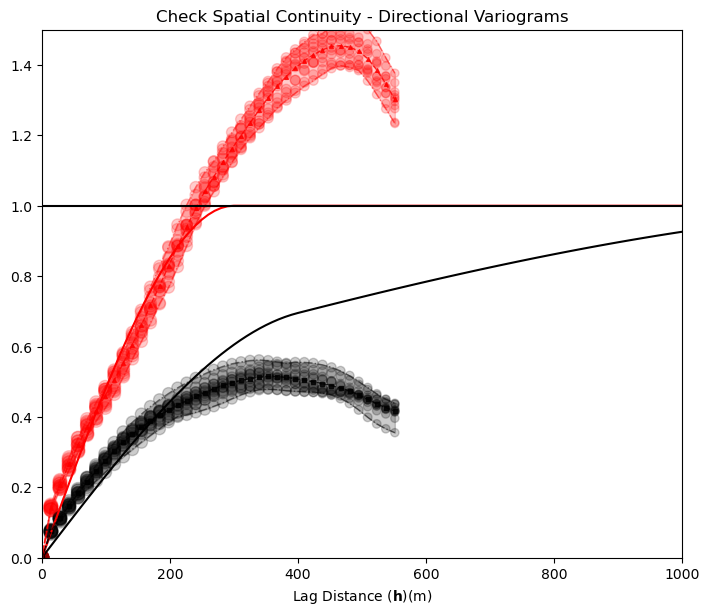

In [16]:
nlag = 40
nlag = min(nlag,min(nx,ny)-1)
gamma_maj = np.zeros([nlag,nreal]); gamma_min = np.zeros([nlag,nreal])
npps_maj = np.zeros([nlag,nreal]); npps_min = np.zeros([nlag,nreal]);

if dataset == 1:
    ixd_maj = 1; iyd_maj = -1; ixd_min = 1; iyd_min = 1

for ireal in range(0,nreal):
    lags, gamma_maj[:,ireal], npps_maj[:,ireal] = geostats.gam(por_sim[ireal,:,:],tmin,tmax,xsiz,ysiz,ixd=ixd_maj,iyd=iyd_maj,nlag=nlag,isill=1.0);
    lags, gamma_min[:,ireal], npps_min[:,ireal] = geostats.gam(por_sim[ireal,:,:],tmin,tmax,xsiz,ysiz,ixd=ixd_min,iyd=iyd_min,nlag=nlag,isill=1.0);
gamma_maj[0,:] = 0.0; gamma_min[0,:] = 0.0
   
index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=100,xlag=10,azm=azi_maj,vario=vmodel);
index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=100,xlag=10,azm=azi_maj+90.0,vario=vmodel);
        
plt.subplot(111)
plt.plot(lags_maj,gmod_maj,color = 'black')
plt.plot(lags_min,gmod_min,color = 'red')
#vargplot('Porosity',lags,gamma_maj[:,0],gamma_min[:,0],npps_maj[:,0],npps_min[:,0],vmodel,azi=135.0,atol=22.5,sill=1.0)     # plot the variogram
for ireal in range(1,nreal):
    plt.scatter(lags,gamma_maj[:,ireal],color = 'black',s = npps_maj[:,ireal]*0.01,alpha = 0.2)
    plt.scatter(lags,gamma_min[:,ireal],color = 'red',s = npps_min[:,ireal]*0.01,alpha = 0.2)
plt.ylim([0,1.5]); plt.title('Check Spatial Continuity - Directional Variograms')
plt.scatter(lags,np.average(gamma_maj,axis=1),marker='s',color = 'black',s = 7,alpha = 0.8)
plt.plot(lags,np.average(gamma_maj,axis=1),color = 'black',linewidth = 1,alpha = 0.8,linestyle='--')
plt.scatter(lags,np.average(gamma_min,axis=1),marker='^',color = 'red',s = 7,alpha = 0.8)
plt.plot(lags,np.average(gamma_min,axis=1),color = 'red',linewidth = 1,alpha = 0.8,linestyle='--')
plt.plot(lags,np.min(gamma_maj,axis=1),color = 'black',linewidth = 1,alpha = 0.5,linestyle='-.')
plt.plot(lags,np.max(gamma_maj,axis=1),color = 'black',linewidth = 1,alpha = 0.5,linestyle='-.')
plt.fill_between(lags,np.min(gamma_maj,axis=1),np.max(gamma_maj,axis=1),color='black',alpha=0.2)
plt.plot(lags,np.min(gamma_min,axis=1),color = 'red',linewidth = 1,alpha = 0.5,linestyle='-.')
plt.plot(lags,np.max(gamma_min,axis=1),color = 'red',linewidth = 1,alpha = 0.5,linestyle='-.')
plt.fill_between(lags,np.min(gamma_min,axis=1),np.max(gamma_min,axis=1),color='red',alpha=0.2)
plt.xlim([0,1000]); plt.xlabel(r'Lag Distance ($\bf{h}$)(m)')
plt.plot([0,1000],[1.0,1.0],color='black')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

Note the cyclicity was not in the variogram model, but it is impose by the data. There is some inflation of short scale discontinuity that may the result of the limited model resolution.

#### Model Check \#6: Local Uncertainty Model - e-type and Conditional Standard Deviation

Finally, we should visualize the local expection and uncertainty model. To do this we calculate and plot the expectation and standard deviation of the realizations over all cell locations. What are we checking?

* **expectation matches data and trends** - the expectation should be consistent with data and trend models or the stationary mean in the absence of a trend model
* **low uncertainty near data** - the uncertainty should be minimized near conditioning data and maximize beyond the range of any conditioning data
* **heteroscedasticity or homoscedasticity** - the assumptions of homoscedasticity or heteroscedasticity will be apparent in the local standard deviation model and can be accessed for appropriateness. 

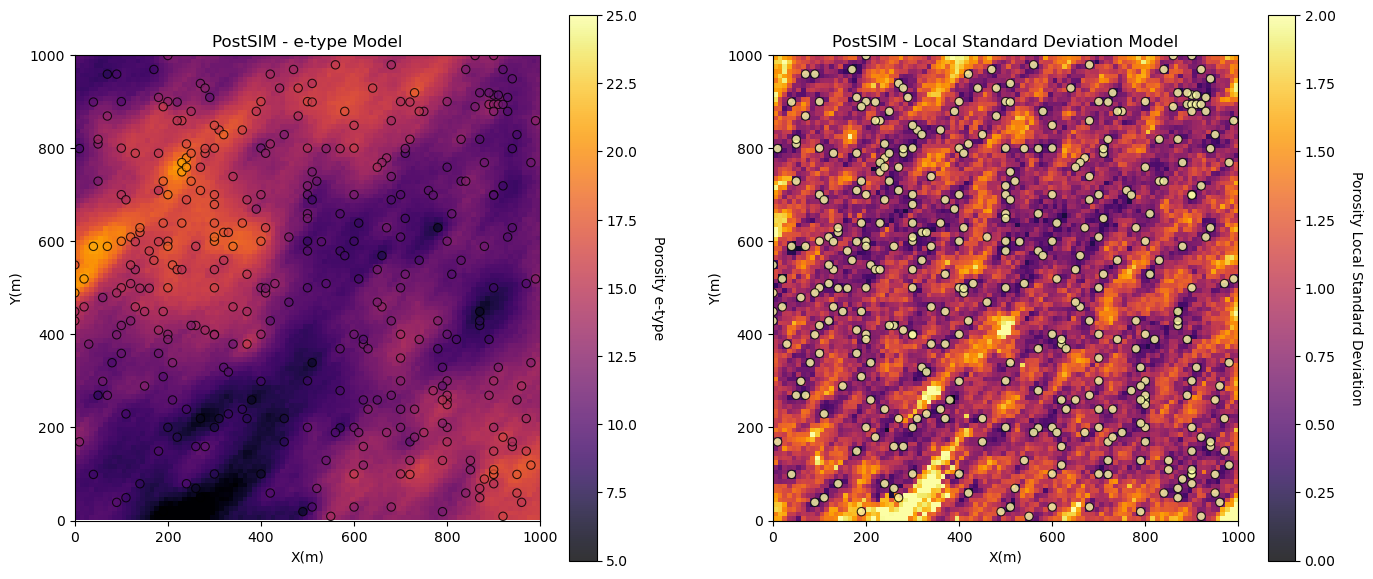

In [17]:
e_type = geostats.local_expectation(por_sim)
local_stdev = geostats.local_standard_deviation(por_sim)

plt.subplot(2,2,1)
GSLIB.locpix_st(e_type,xmin,xmax,ymin,ymax,xsiz,5,25,df,'X','Y','Porosity','PostSIM - e-type Model','X(m)','Y(m)','Porosity e-type',cmap)

plt.subplot(2,2,2)
GSLIB.locpix_st(local_stdev,xmin,xmax,ymin,ymax,xsiz,0.0,2.0,df,'X','Y','Porosity','PostSIM - Local Standard Deviation Model','X(m)','Y(m)','Porosity Local Standard Deviation',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

#### Comments

This was a basic demonstration of model checking with GeostatsPy. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  
  